In [62]:
pip install geopandas --user

  Using cached geopandas-0.13.2-py3-none-any.whl (1.1 MB)
  Using cached fiona-1.9.6-cp38-cp38-win_amd64.whl (22.9 MB)
  Using cached shapely-2.0.4-cp38-cp38-win_amd64.whl (1.5 MB)
  Using cached pyproj-3.5.0-cp38-cp38-win_amd64.whl (5.1 MB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [288]:
import pandas as pd
import xlrd 


import re
import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

import geopandas as gpd
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import f1_score

In [16]:
cleansearchdata = pd.read_csv('CleanSearchData.csv')
cleanstreetdata = pd.read_csv('CleanStreetData.csv')
pas_data_borough = pd.read_csv('pas_data_borough.csv')
pas_data_mps = pd.read_csv('pas_data_MPS.csv')



In [55]:
cleansearchdata # crime data only from 2021-2023

,Type,Date,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Borough
0,Person search,2021-03-31T23:01:00+00:00,51.500886,-0.068284,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,southwark
1,Person search,2021-03-31T23:01:00+00:00,51.500886,-0.068284,Male,10-17,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,southwark
2,Person search,2021-03-31T23:01:00+00:00,51.500886,-0.068284,Male,NaN,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,southwark
3,Person search,2021-03-31T23:03:00+00:00,51.378427,-0.102657,Male,25-34,Black/African/Caribbean/Black British - Any ot...,Black,Criminal Justice and Public Order Act 1994 (se...,Anything to threaten or harm anyone,A no further action disposal,croydon
4,Person search,2021-03-31T23:04:00+00:00,51.605538,0.215400,Male,25-34,Other ethnic group - Not stated,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,havering
...,...,...,...,...,...,...,...,...,...,...,...,...
377563,Vehicle search,2023-08-11T00:21:00+00:00,51.475014,-0.134969,NaN,NaN,NaN,NaN,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,haringey
377564,Person search,2023-08-11T00:21:00+00:00,51.563863,0.007608,Male,18-24,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,islington
377565,Person and Vehicle search,2023-08-11T00:30:00+00:00,51.475014,-0.134969,Male,NaN,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,hackney
377566,Person search,2023-08-11T00:30:00+00:00,51.513498,-0.130169,Male,NaN,Black/African/Caribbean/Black British - Any ot...,Black,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,havering


### dictionary for mps averages per borough ###

In [18]:
all_boroughs = pas_data_borough['Borough'].unique()
mps_mean_values_per_borough = dict()
for b in all_boroughs:
    mps = pas_data_borough[pas_data_borough['Borough'] == b][['Date', 'Proportion', 'MPS']]
    
    mps['date'] = pd.to_datetime(mps['Date'])
    mps['year'] = mps['date'].dt.year
    
    all_years = mps['year'].unique()
    
    mean_values = dict()
    for y in all_years:
        value = mps[mps['year'] == y]['MPS'].mean()
        mean_values[y] = value
    
    mps_mean_values_per_borough[b] = mean_values

#mps_mean_values_per_borough #(the dictionary with the average mps value per year, per borough) 2015-2023

In [19]:
df_mps = pd.DataFrame.from_dict(mps_mean_values_per_borough, orient='index')
df_mps 
# double check if this is correct

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Barking and Dagenham,0.648571,0.642143,0.667812,0.665,0.614375,0.588125,0.591562,0.571563,0.5225,0.499063
Barnet,0.648571,0.642143,0.667812,0.665,0.614375,0.588125,0.591562,0.571563,0.5225,0.499063
Bexley,0.648571,0.642143,0.667812,0.665,0.614375,0.588125,0.591562,0.571563,0.5225,0.499063
Brent,0.648571,0.642143,0.667812,0.665,0.614375,0.588125,0.591562,0.571563,0.5225,0.499063
Bromley,0.648571,0.642143,0.667812,0.665,0.614375,0.588125,0.591562,0.571563,0.5225,0.499063
Camden,0.648571,0.642143,0.667812,0.665,0.614375,0.588125,0.591562,0.571563,0.5225,0.499063
Croydon,0.648571,0.642143,0.667812,0.665,0.614375,0.588125,0.591562,0.571563,0.5225,0.499063
Ealing,0.648571,0.642143,0.667812,0.665,0.614375,0.588125,0.591562,0.571563,0.5225,0.499063
Enfield,0.648571,0.642143,0.667812,0.665,0.614375,0.588125,0.591562,0.571563,0.5225,0.499063
Greenwich,0.648571,0.642143,0.667812,0.665,0.614375,0.588125,0.591562,0.571563,0.5225,0.499063


### From here are the necessary cells for the create scatter function ###

In [20]:
pas_data_borough # proportion is how many people answer positive, mps is the police's own score
all_boroughs = pas_data_borough['Borough'].unique()
proportion_mean_values_per_borough = dict()
for b in all_boroughs:
    conf = pas_data_borough[pas_data_borough['Borough'] == b][['Date', 'Proportion', 'MPS']]
    
    conf['date'] = pd.to_datetime(conf['Date'])
    conf['year'] = conf['date'].dt.year
    
    all_years = conf['year'].unique()
    
    mean_values = dict()
    for y in all_years:
        value = conf[conf['year'] == y]['Proportion'].mean()
        mean_values[y] = value
    
    proportion_mean_values_per_borough[b] = mean_values

#proportion_mean_values_per_borough (the dictionary with the average proportion value per year, per borough)

In [21]:
df_b = pd.DataFrame.from_dict(proportion_mean_values_per_borough, orient='index')

In [22]:
#BCN = better column names
BCN = []
BCN_e = []
BCN_w = []
BCN_p = []
BCN_c = []
i = 4
while i < 24:
    all_4 = 'Economically Inactive_{}'.format(i), 'Working Age_{}'.format(i), 'Percent_{}'.format(i), 'Confidence_{}'.format(i)
    e = 'Economically Inactive_{}'.format(i)
    w = 'Working Age_{}'.format(i)
    p = 'Percent_{}'.format(i)
    c = 'Confidence_{}'.format(i)
    BCN.extend(all_4)
    BCN_e.append(e)
    BCN_w.append(w)
    BCN_p.append(p)
    BCN_c.append(c)
    i += 1
BCN.insert(0, 'Code')
BCN.insert(1, 'Area')
#BCN_e.insert(0, 'Code')
BCN_e.insert(0, 'Area')
#BCN_w.insert(0, 'Code')
BCN_w.insert(0, 'Area')
#BCN_p.insert(0, 'Code')
BCN_p.insert(0, 'Area')
#BCN_c.insert(0, 'Code')
BCN_c.insert(0, 'Area')
#BCN
#BCN_e
#BCN_w
#BCN_p
#BCN_c

In [23]:
def clean_database_provider(sheetname= str()):
    em_nan = pd.read_excel('economic-inactivity-by-gender-reason.xlsx', sheet_name= sheetname)
    em = em_nan.dropna().copy()
    em

    yet = []
    i = 4
    while i < 24:
        g = 'Economically Inactive_{}'.format(i), 'Working Age_{}'.format(i), 'Percent_{}'.format(i), 'Confidence_{}'.format(i) 
        yet.extend(g)
        i += 1
    yet.insert(0, 'Code')
    yet.insert(1, 'Area')
    yet
    em.columns = yet
    em = em.drop(0)
    demographic = em.copy()
    
    return demographic


In [325]:
males = clean_database_provider('Males')[BCN_p]
females = clean_database_provider('Females')[BCN_p]
both = clean_database_provider('All persons')[BCN_p]
#males.to_csv("Economically inactive males ")
males.to_csv("economically inactive males percentage.csv")
females.to_csv("economically inactive females percentage.csv")
both.to_csv("economically inactive males and females percentage.csv")

In [271]:
def get_df(borough = str(), gender = str()):
    # gender options = All persons, Females, Males
    demo = clean_database_provider(gender)
    subset = demo[demo['Area'] == borough][BCN_p] # e = economic inactive, w = working age, p = percentage(that are inactive), c = confidence int.
    final = subset.set_index('Area').T
    

    time_sync = final.loc['Percent_14':].copy().reset_index()
    conf_metric = df_b.loc[[borough]].T.reset_index() # df_b is a variable for proportion metric, mps score = df_mps
    # Economically Inactive_14, Working Age_14, Percent_14, Confidence_14


    df = pd.concat([time_sync, conf_metric], axis=1)
    df.columns = ['type_index', '#', 'time_index', 'conf']
    df.set_index('time_index')
    return df

In [436]:
def get_df_yearly(year:int(), column:str()):
    needed_boroughs = df_b.index[:len(df_b.index)-2]
    base = clean_database_provider('All persons')
    basis = base.loc[3:33]

    df_y = df_b[:-2]
    
    ts = basis[BCN_p][[column]].copy().reset_index()
    cm = df_y[[year]].reset_index()
    df = pd.concat([ts, cm], axis=1)
    df.columns = ['index', '#', 'borough_index', 'conf']

    return df

In [484]:
percent = BCN_p[11:]
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [478]:
def plot_regression_line_2(x, y, b, year: int()):  
    # plotting the actual points as scatter plot 
    plt.scatter(x, y, color = "m", 
        marker = "o", s = 30) 

    # predicted response vector 
    y_pred = b[0] + b[1]*x 
    
    # get piersons' r
    r, p = sp.stats.pearsonr(x=x, y=y)
    

    # plotting the regression line 
    plt.plot(x, y_pred, color = "g") 
    plt.title('Linear regression model for the Percentage of unemployed and confidence metric for {} '.format(year))
    plt.xlabel('Percentage of unemployed habitants in the year {}'.format(year))
    plt.ylabel('Confidence metric')
    #plt.text(.6, .15, "Pearson's r ={:.2f}".format(r), transform=ax.transAxes);
    
    plt.savefig("linear-plots/linear regression model to get the MSE & MAE for {}.jpg".format(year), bbox_inches='tight', dpi=300)
    plt.show()
    
    return y_pred

Percent_14 2014


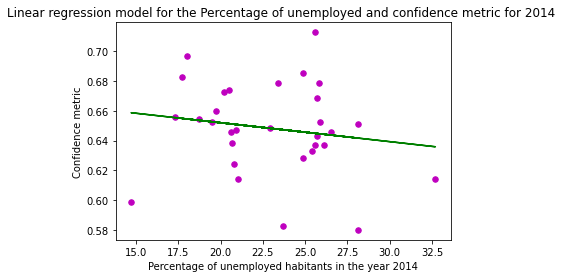

Percent_15 2015


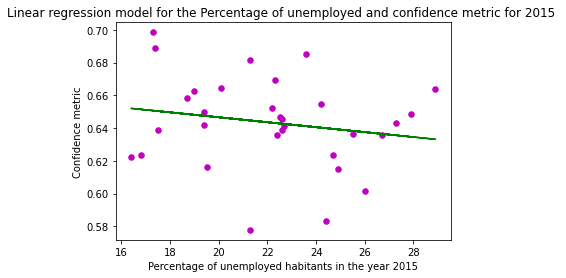

Percent_16 2016


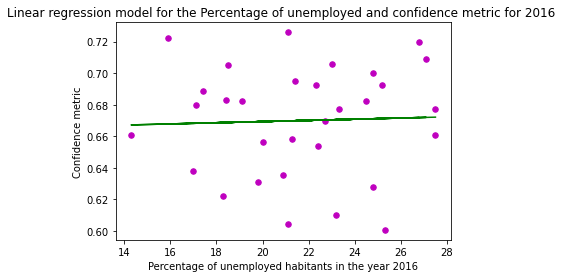

Percent_17 2017


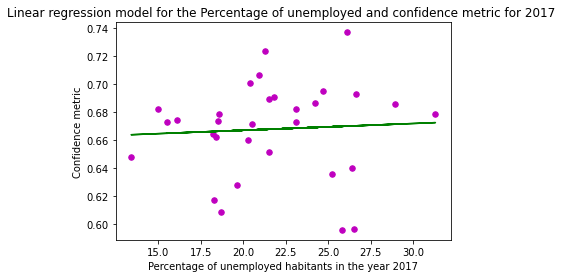

Percent_18 2018


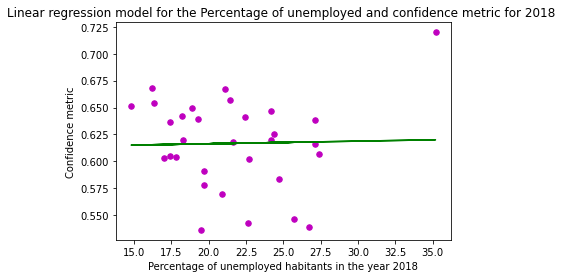

Percent_19 2019


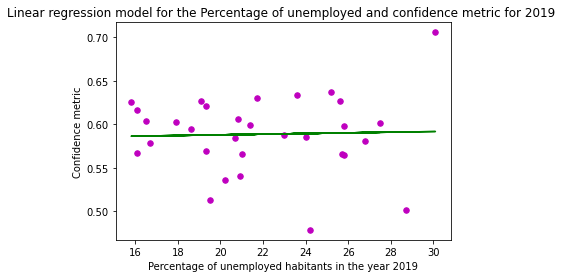

Percent_20 2020


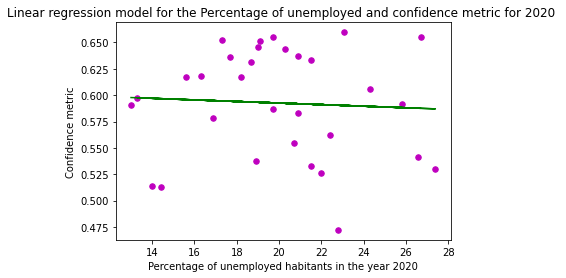

Percent_21 2021


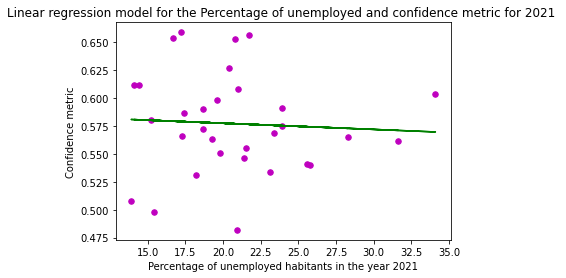

Percent_22 2022


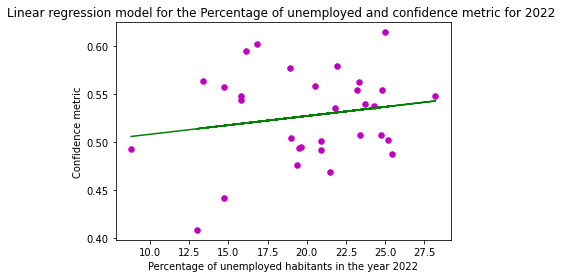

Percent_23 2023


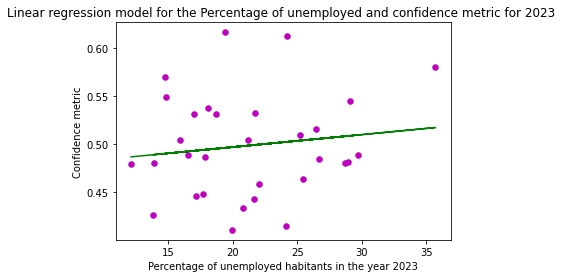

In [542]:
yearly_correlation = dict()
dictionary_2 = dict()
for columns, year in zip(percent, years):
    print(columns, year)
    u = get_df_yearly(year, columns)['#']
    v = get_df_yearly(year, columns)['conf']
    r, p = sp.stats.pearsonr(x=u, y=v)
    yearly_correlation[year] = r
    
    w = estimate_coef(u, v)
    
    y_pred_2 = plot_regression_line_2(u, v, w, year)
    MSE_2 = mean_squared_error(v, y_pred_2)
    MAE_2 = mae(v, y_pred_2)
    
    dictionary_2[year] = {'MSE': MSE_2, 'MAE': MAE_2}

In [544]:
dictionary_2
metrics_2 = pd.DataFrame.from_dict(dictionary_2).T
metrics_2
metrics_2.to_csv('linear-plots/MSE and MAE for linear-plots-yearly-good-version.csv')

In [272]:
def create_scatter(data=pd.DataFrame(), borough = str()):
    r, p = sp.stats.pearsonr(x=data['#'], y=data['conf'])
    
    sns.scatterplot(x=data["#"], y=data["conf"], hue=data['time_index'], palette="deep");
    plt.title('Correlation between total nr of economically inactive habitants and confidence metric for {}'.format(borough))
    plt.xlabel('total nr of economically inactive habitants')
    plt.ylabel('confidence coefficient')
    

    
    ax = plt.gca() # Get a matplotlib's axes instance
    plt.text(.7, .1, "Pearson's r ={:.2f}".format(r), transform=ax.transAxes);
    plt.savefig('plots/Scatterplot with Pearson r for {} habitants.jpg'.format(borough), bbox_inches='tight', dpi=300)
    plt.show()

In [273]:
#Mean Squared error
#Mean Absolute error
#F1 Score

def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 

    # mean of x and y vector 
    m_x = np.mean(x) 
    m_y = np.mean(y) 

    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 

    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return (b_0, b_1)

In [314]:
def plot_regression_line(x, y, b, borough: str()):  
    # plotting the actual points as scatter plot 
    plt.scatter(x, y, color = "m", 
        marker = "o", s = 30) 

    # predicted response vector 
    y_pred = b[0] + b[1]*x 
    

    # plotting the regression line 
    plt.plot(x, y_pred, color = "g") 
    plt.title('Linear regression model for the Percentage of unemployed and confidence metric for {} habitants'.format(borough))
    plt.xlabel('Percentage of unemployed habitants in {}'.format(borough))
    plt.ylabel('Confidence metric')
    plt.savefig("linear-plots/linear regression model to get the MSE & MAE for {}.jpg".format(borough), bbox_inches='tight', dpi=300)
    plt.show()
    
    return y_pred

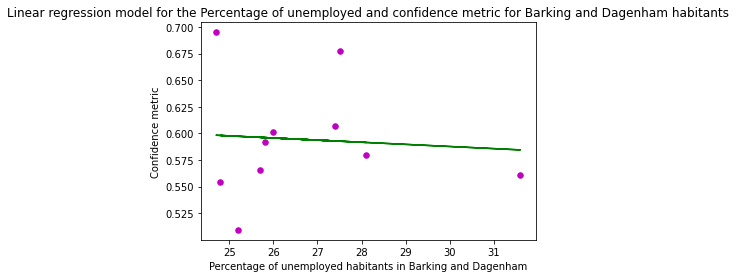

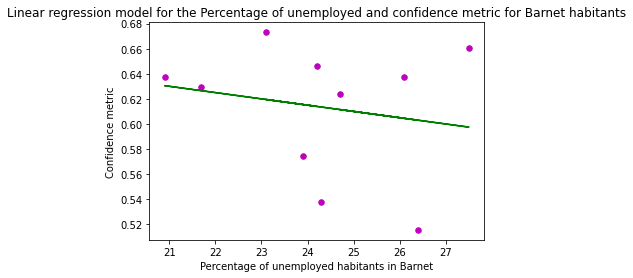

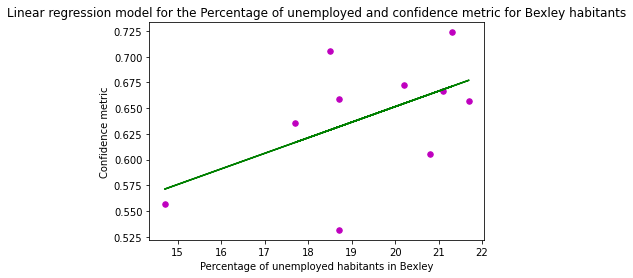

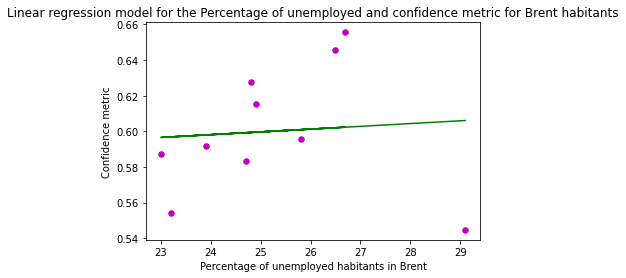

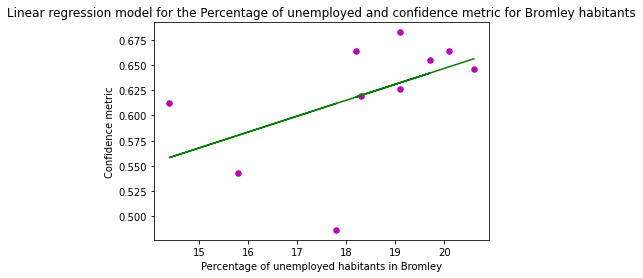

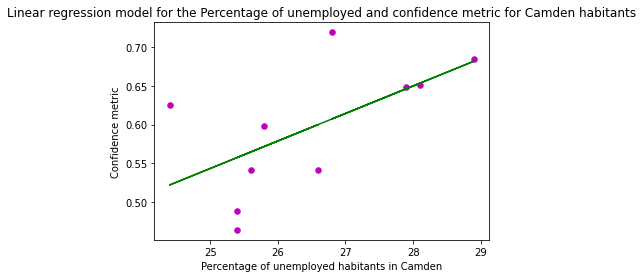

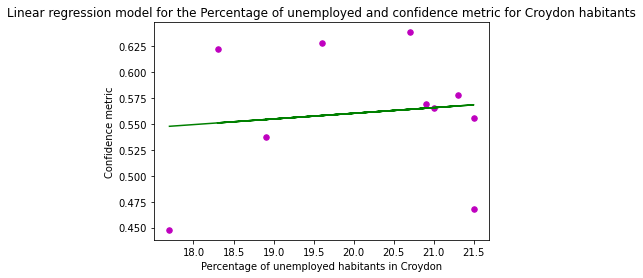

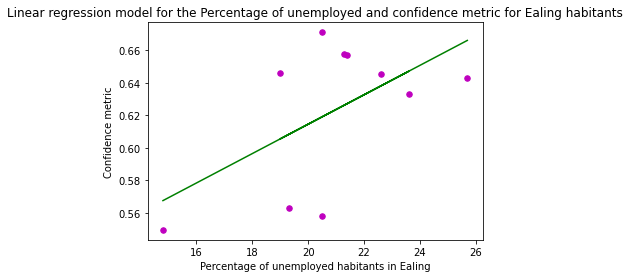

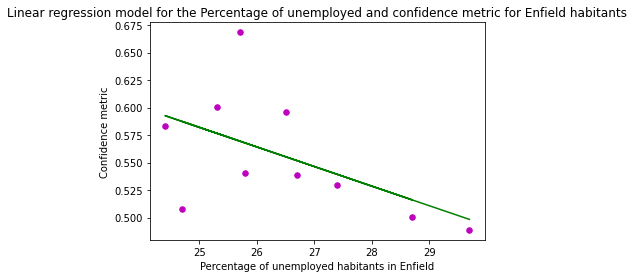

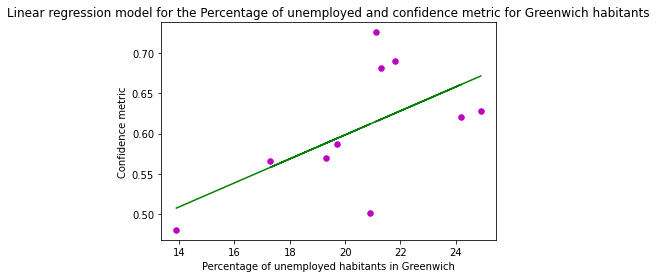

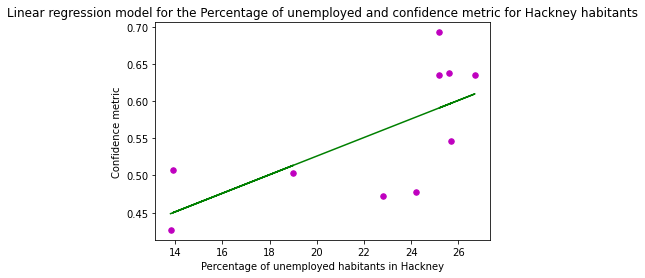

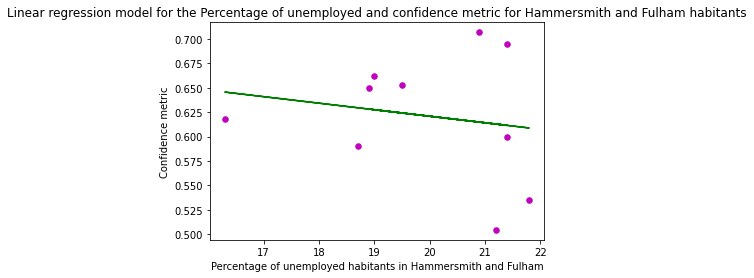

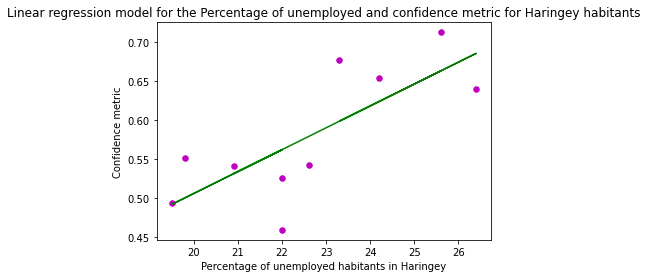

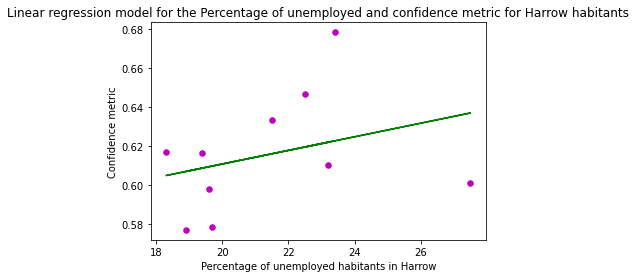

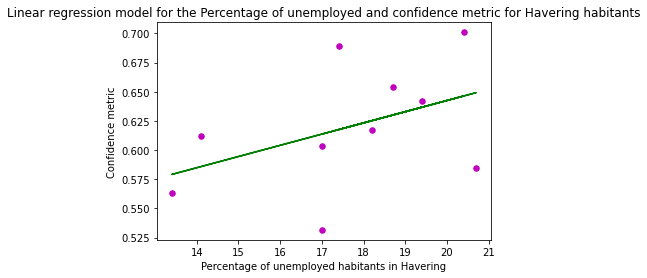

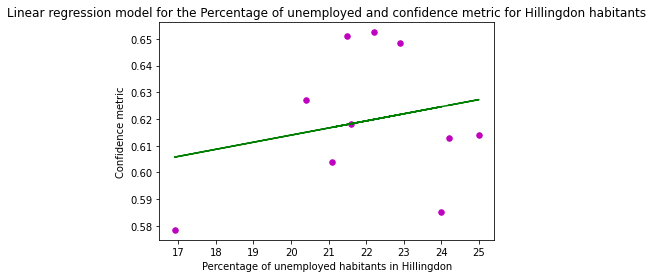

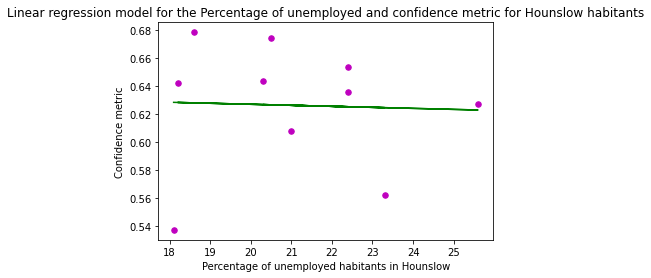

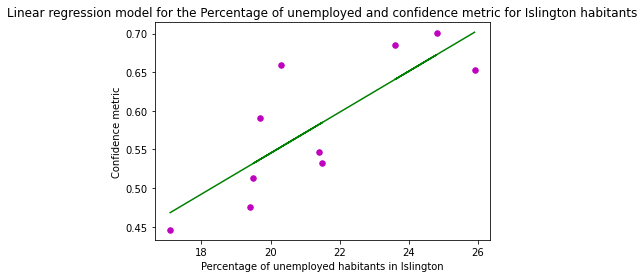

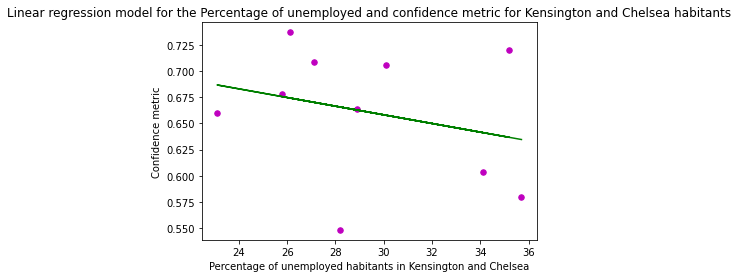

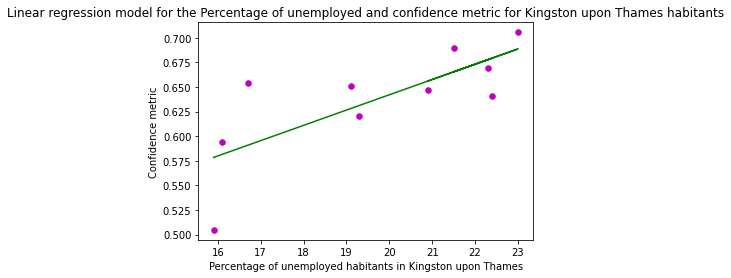

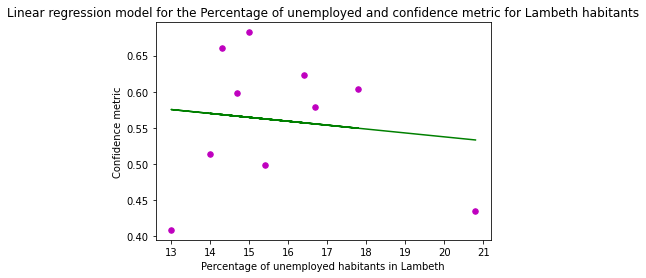

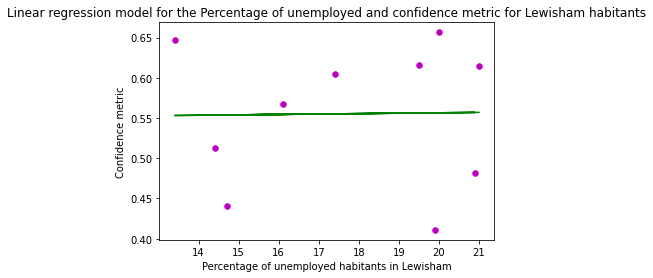

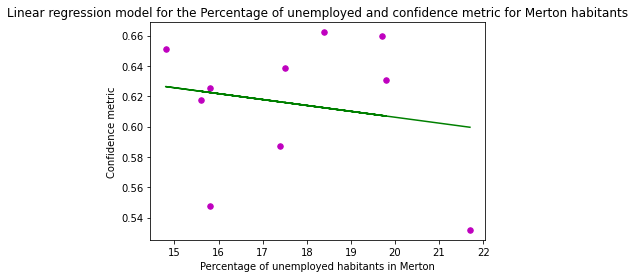

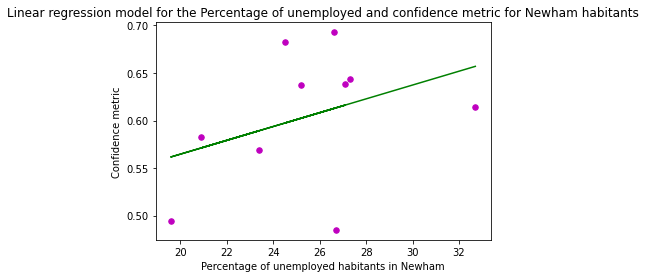

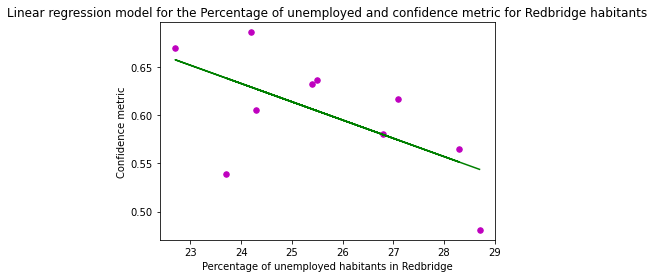

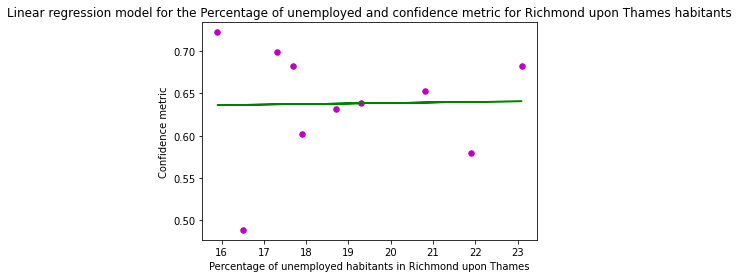

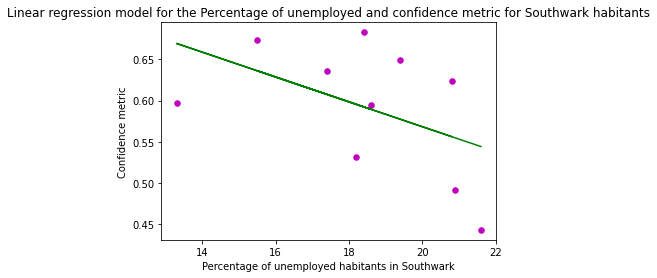

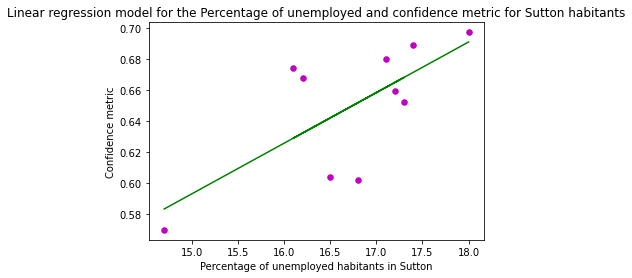

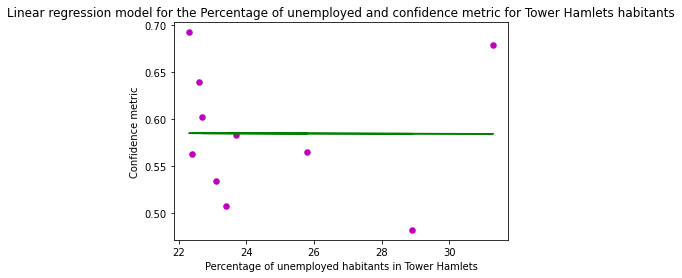

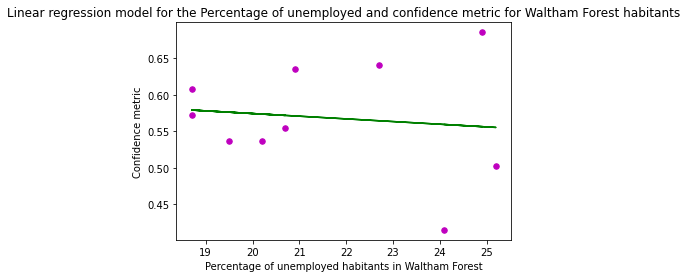

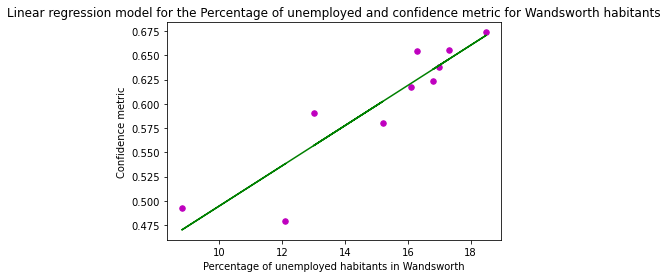

In [315]:
dictionary = dict()
for borough in plot_boroughs:
    

    x = get_df(borough, 'All persons')['#']
    y = get_df(borough, 'All persons')['conf']
    hue = get_df(borough, 'All persons')['time_index']

    b = estimate_coef(x, y)
    
    y_pred = plot_regression_line(x, y, b, borough)
    MSE = mean_squared_error(y, y_pred)
    MAE = mae(y, y_pred)
    
    dictionary[borough] = {'MSE': MSE, 'MAE': MAE}


In [490]:
metrics = pd.DataFrame.from_dict(dictionary).T
metrics.to_csv('linear-plots/MSE and MAE for linear-plots-boroughly.csv')

In [319]:
metrics

,MSE,MAE
Barking and Dagenham,0.002808,0.040380
Barnet,0.002431,0.040855
Bexley,0.002408,0.038769
Brent,0.001182,0.028237
Bromley,0.002514,0.035765
Camden,0.004195,0.049773
Croydon,0.003609,0.046030
Ealing,0.001316,0.032310
Enfield,0.001982,0.032716
Greenwich,0.003775,0.049654


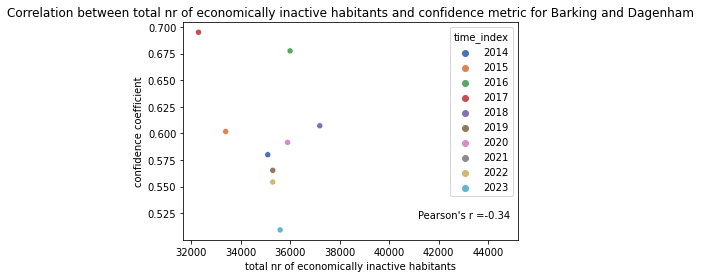

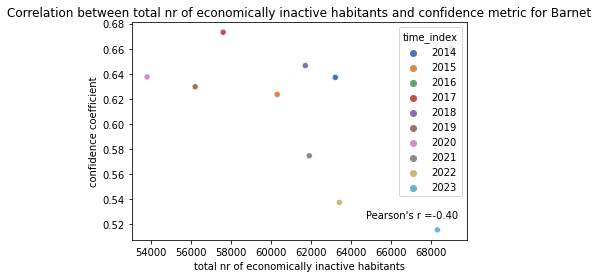

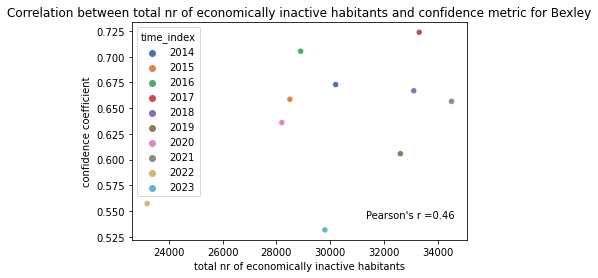

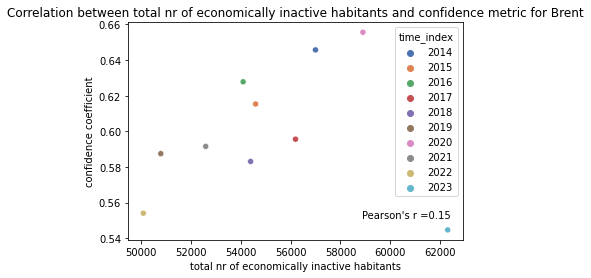

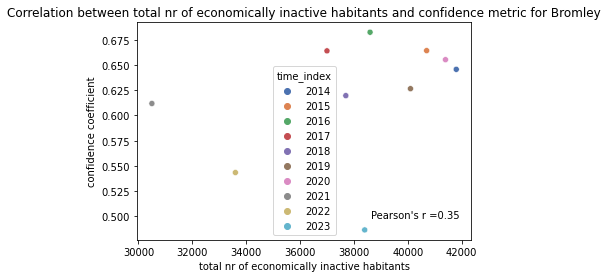

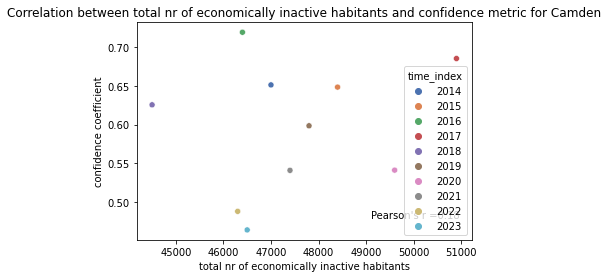

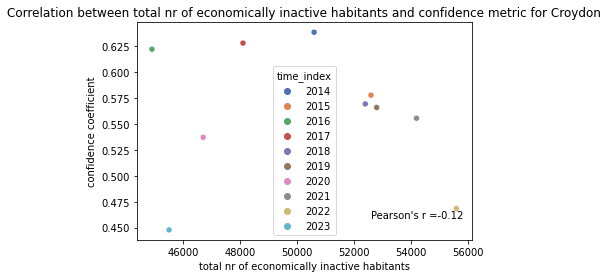

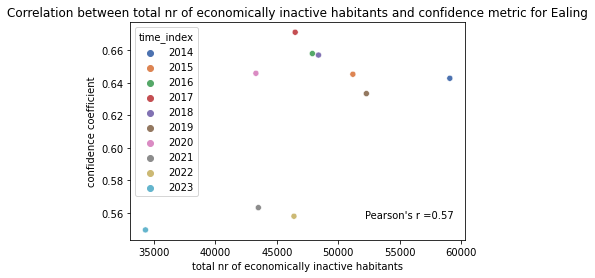

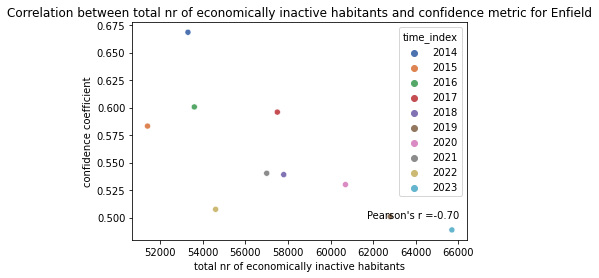

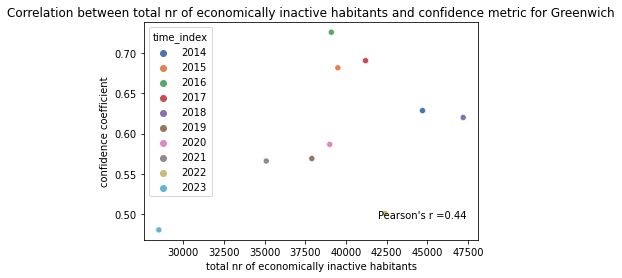

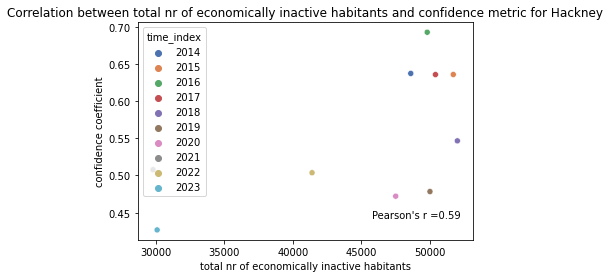

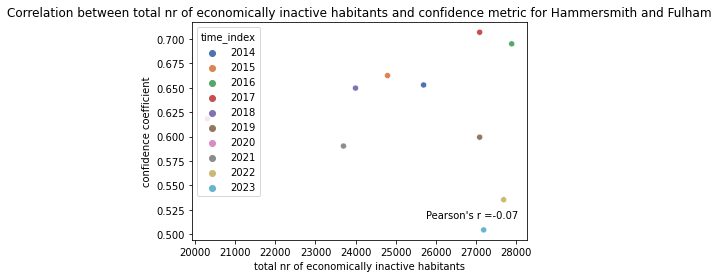

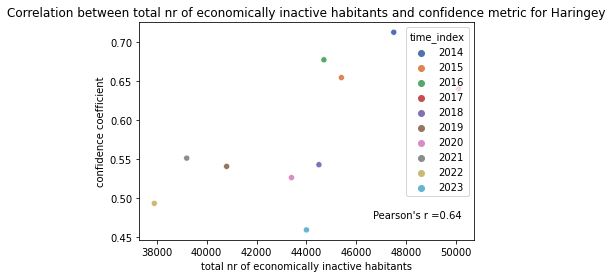

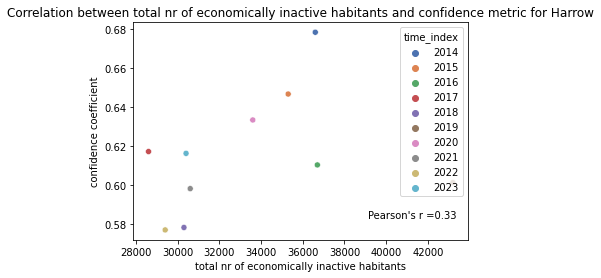

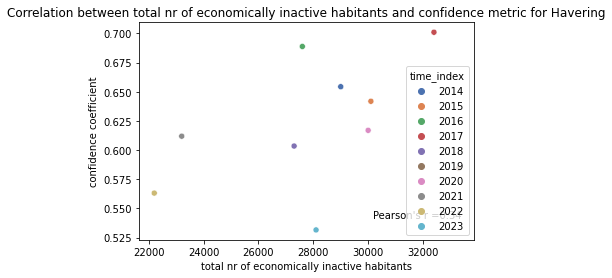

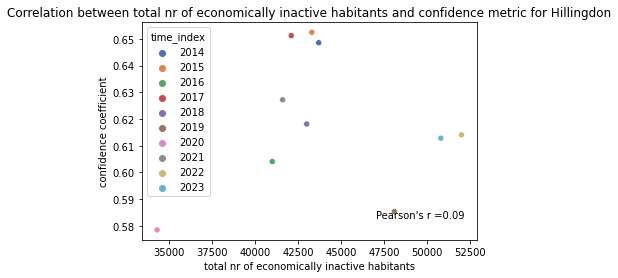

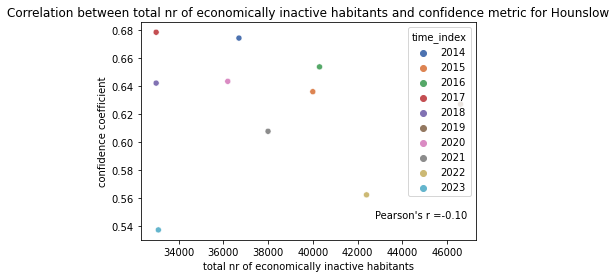

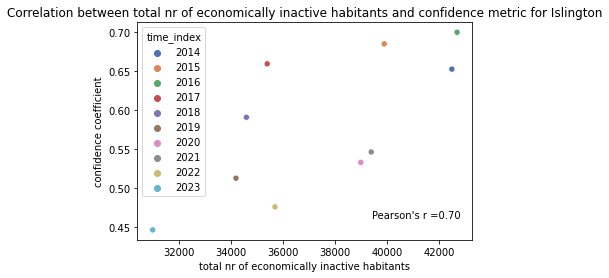

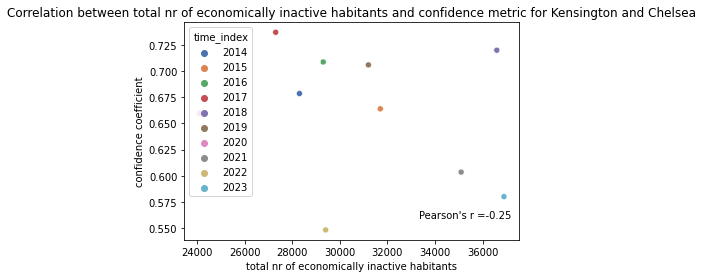

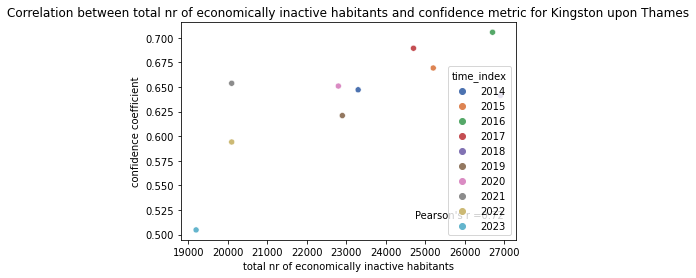

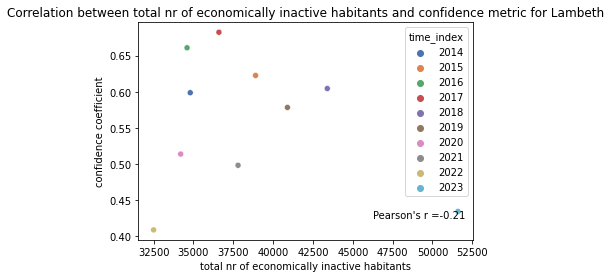

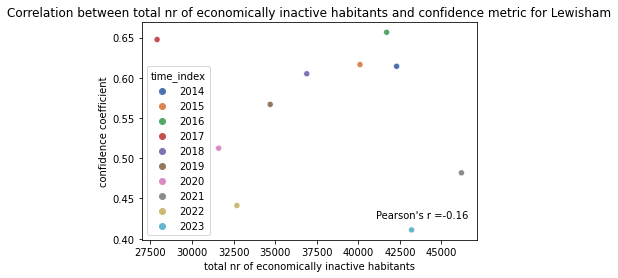

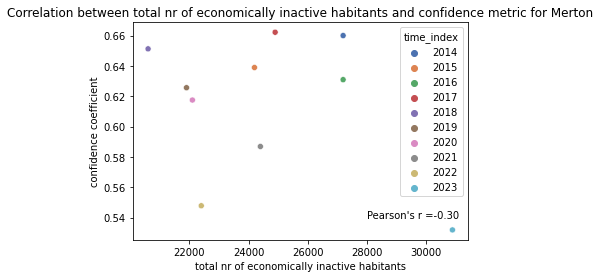

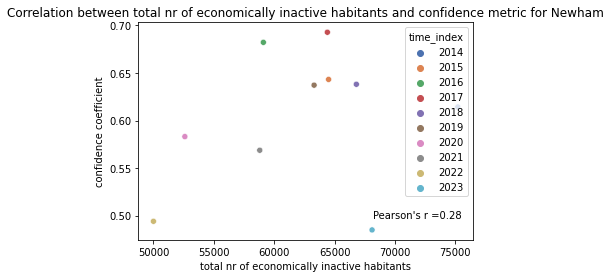

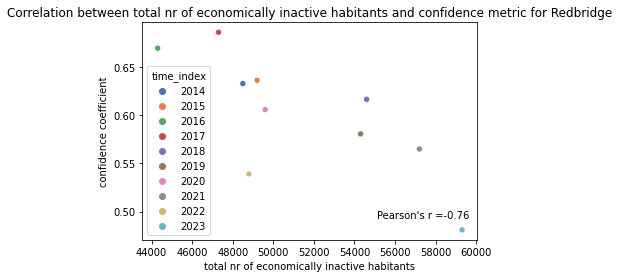

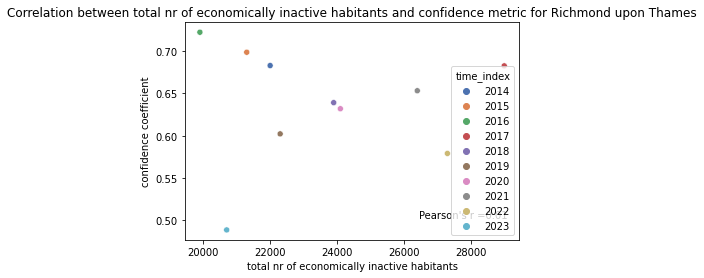

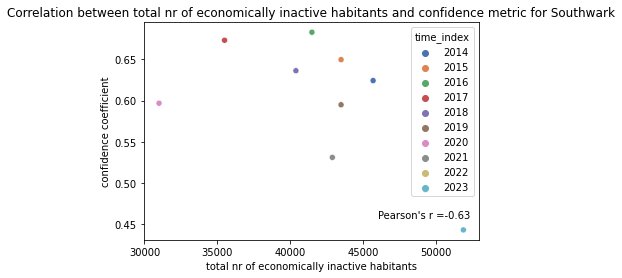

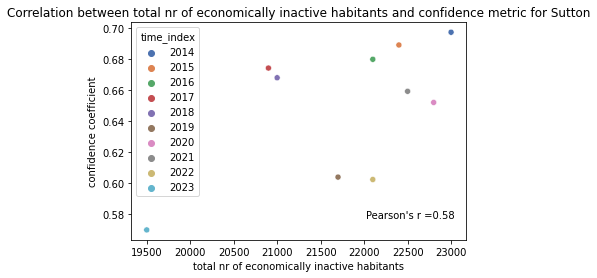

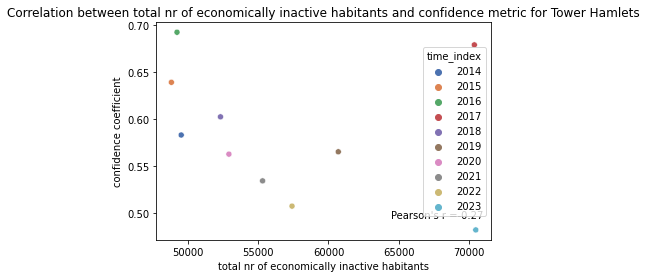

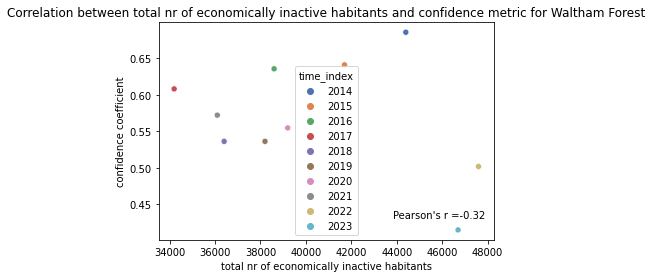

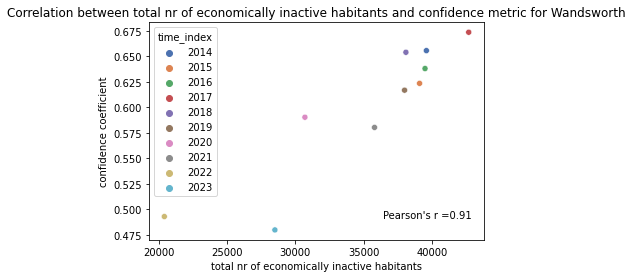

In [234]:
# figure out why the dataframes get combined when automatizing the process
# fixed it

for bor in plot_boroughs:
    dataframe = get_df(bor, 'All persons')
    create_scatter(dataframe, bor)
    


### The function create scatter will provide a scatterplot with pearson's r correlation coefficient for a given borough and demographic for the range 2014-2023 which contains the confidence metric data ###

In [27]:
all_boroughs # based of the pas_data_borough database but the economical database doesn't include City of westminster

array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney',
       'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth',
       'City of Westminster', 'Richmond Upon Thames'], dtype=object)

In [237]:
males_correlation = dict() # denoted by 1
females_correlation = dict() # denoted by 2
all_persons_correlation = dict() # denoted by 3
for borough in all_boroughs:
    if (borough != 'Richmond Upon Thames') & (borough != 'City of Westminster'):
        corr_data_1 = get_df(borough, 'Males')
        corr_data_2 = get_df(borough, 'Females')
        corr_data_3 = get_df(borough, 'All persons')
        r1, p1 = sp.stats.pearsonr(x=corr_data_1['#'], y=corr_data_1['conf'])
        r2, p2 = sp.stats.pearsonr(x=corr_data_2['#'], y=corr_data_2['conf'])
        r3, p3 = sp.stats.pearsonr(x=corr_data_3['#'], y=corr_data_3['conf'])

        males_correlation[borough] = r1
        females_correlation[borough] = r2
        all_persons_correlation[borough] = r3

#males_correlation
#females_correlation
all_persons_correlation

{'Barking and Dagenham': -0.3403634376544289,
 'Barnet': -0.40427092327434827,
 'Bexley': 0.4592788549962967,
 'Brent': 0.1457769922447065,
 'Bromley': 0.351244121483046,
 'Camden': 0.181049443025534,
 'Croydon': -0.12346025861806767,
 'Ealing': 0.5660839031874043,
 'Enfield': -0.7011788646775631,
 'Greenwich': 0.4390400270501812,
 'Hackney': 0.5929394375666523,
 'Hammersmith and Fulham': -0.07216745395896795,
 'Haringey': 0.6413060685523138,
 'Harrow': 0.32723656485085895,
 'Havering': 0.34436440151244785,
 'Hillingdon': 0.08709690701609396,
 'Hounslow': -0.10234960273162748,
 'Islington': 0.6981793081975871,
 'Kensington and Chelsea': -0.24738121601664953,
 'Kingston upon Thames': 0.7246833901979993,
 'Lambeth': -0.20693361158446094,
 'Lewisham': -0.15878871052116816,
 'Merton': -0.3017709572505996,
 'Newham': 0.2782367602561023,
 'Redbridge': -0.760208346740626,
 'Richmond upon Thames': 0.009993577128249304,
 'Southwark': -0.629993820367262,
 'Sutton': 0.5755344764024002,
 'Tower Ha

### Visualize the correlation distribution over all the boroughs ###

In [242]:
def barplot(data):
    names = list(data.keys())
    values = list(data.values())
    
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.bar(range(len(data)), values, tick_label=names)

    plt.title('Correlation between total nr of economically inactive and proportion metric per borough for females')
    plt.ylabel('proportion metric')
    plt.axhline(y=np.mean(values), color='green')
    plt.xticks(rotation=90)
    plt.savefig("plots/Correlation between total nr of economically inactive and proportion metric per borough for females.jpg", bbox_inches = 'tight')
    plt.show()

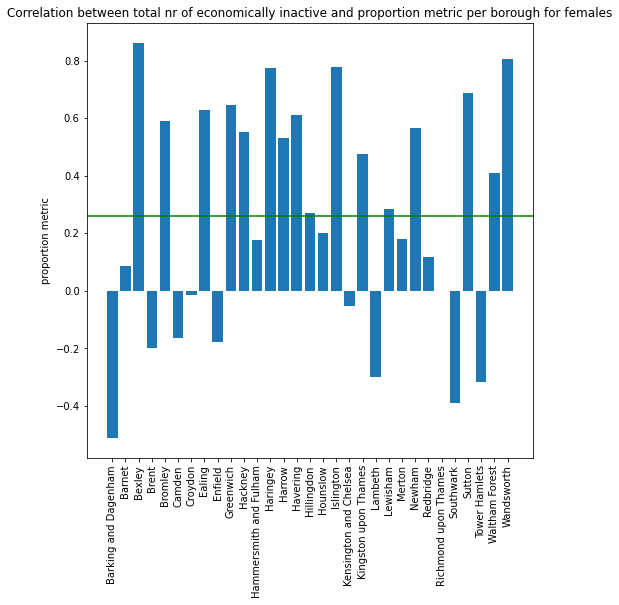

In [243]:
barplot(females_correlation) # get the format rights, not whole picture is saved
# fixed with bbox = 'tight'

### create Koko's map visualization ###

In [71]:
# load in the visualization map
shapefile_path = "London-wards-2018/London-wards-2018_ESRI/London_Ward.shp"
gdf = gpd.read_file(shapefile_path)
boroughs = gdf.dissolve(by='DISTRICT').reset_index()

### create and save the results ###

In [527]:
#get_df('City of Westminster', 'All persons')
westminster = clean_database_provider('All persons')
west = westminster[westminster['Area'] == 'Westminster'][BCN_p].T
uvw = df_b.loc[['City of Westminster']].T
westminst = west['Percent_14':]
r, p = sp.stats.pearsonr(x=westminst[34], y=uvw['City of Westminster'])
r

0.4847290897548111

In [540]:
def create_map_visual(data):
    data['City of Westminster'] = 0.484729
    df_correlation = pd.DataFrame.from_dict(data, orient='index')
    
    final_boroughs = boroughs.merge(df_correlation, left_on='DISTRICT', right_index=True, how='left')
    final_boroughs = final_boroughs.rename(columns={0: "correlation"})

    missing_data_boroughs = final_boroughs[final_boroughs['correlation'].isnull()]
    #print(missing_data_boroughs)
    
    
    fig, ax = plt.subplots(figsize=(15, 8))
    final_boroughs.boundary.plot(ax=ax, color='black')
    final_boroughs.plot(column='correlation', cmap='Blues', legend=True, ax=ax)

    # Remove axes and extra edges
    ax.set_axis_off()
    ax.margins(0)

    # Add legend for missing data
    #handles, labels = ax.get_legend_handles_labels()
    #handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Missing data', markerfacecolor='red', markersize=10))
    #ax.legend(handles=handles, loc='upper right')

    plt.title("Percentage of economical inactivaty and confidence metric correlation for people living in the London boroughs", size = 20)
    plt.savefig("map-plots/Correlation coefficient for confidence metric and percentage of un-employed people in London.jpg", bbox_inches = 'tight')
    plt.show()
    # facecolor = 'w'

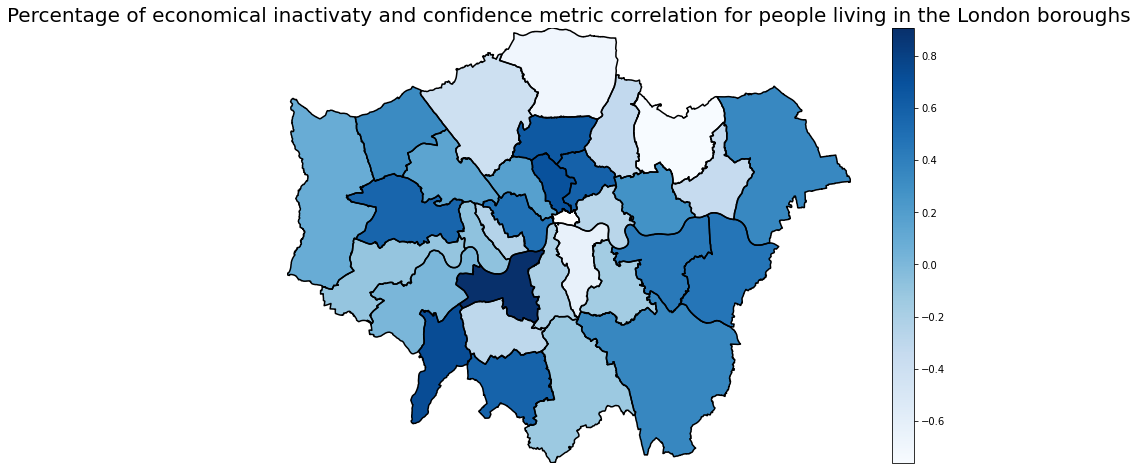

In [541]:
create_map_visual(all_persons_correlation) # make it prettier

In [252]:
#clean_database_provider('Males')
#df_b

males_correlation

{'Barking and Dagenham': 0.30039087309350476,
 'Barnet': -0.7506734417394779,
 'Bexley': -0.47051047269341095,
 'Brent': 0.18069932065714678,
 'Bromley': -0.41340851574943954,
 'Camden': 0.22066002665089163,
 'Croydon': -0.14561224589092742,
 'Ealing': 0.038376221613812184,
 'Enfield': -0.7291204349576947,
 'Greenwich': -0.26773696991796053,
 'Hackney': 0.4129136681947578,
 'Hammersmith and Fulham': -0.29234284640320546,
 'Haringey': -0.18755423524889842,
 'Harrow': -0.22085240070688428,
 'Havering': -0.29911460094136105,
 'Hillingdon': -0.18125881948709993,
 'Hounslow': -0.3210909409878978,
 'Islington': -0.19535368352387525,
 'Kensington and Chelsea': -0.3731031427481756,
 'Kingston upon Thames': 0.905744616477703,
 'Lambeth': 0.045295463793526836,
 'Lewisham': -0.4914190359127948,
 'Merton': -0.457689532048616,
 'Newham': -0.3149447272293896,
 'Redbridge': -0.9089287664013996,
 'Richmond upon Thames': 0.017680811588886514,
 'Southwark': -0.6567733958645563,
 'Sutton': -0.03594482570